In [2]:
#Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from proj2_helpers import *
%load_ext autoreload
%autoreload 2

In [3]:
#Loading the training data
data=pd.read_csv('data_train.csv')
data.head()

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


In [4]:
#Extracting row and column numbers
data['Id']=data['Id'].apply(lambda x: re.findall(r'\d+', str(x)))
data.head()

,Id,Prediction
0,"[44, 1]",4
1,"[61, 1]",3
2,"[67, 1]",4
3,"[72, 1]",3
4,"[86, 1]",5


In [5]:
#Row and column values to features
num_id_data=data
num_id_data[['Row', 'Col']]=pd.DataFrame(data.Id.values.tolist(), index= data.index)
num_id_data=num_id_data.drop(columns='Id')
num_id_data.head()

,Prediction,Row,Col
0,4,44,1
1,3,61,1
2,4,67,1
3,3,72,1
4,5,86,1


In [9]:
cli_vs_mov=num_id_data.pivot(index='Row', columns='Col', values='Prediction')
cli_vs_mov.head()

Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,4.0,NaN,NaN
100,NaN,5.0,NaN,NaN,5.0,NaN,3.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1000,NaN,2.0,4.0,2.0,5.0,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,4.0,2.0,NaN,5.0,1.0,NaN,2.0,3.0
10000,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,2.0,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN


In [10]:
def initialize_clusters(data, k):
    """initialize the k cluster centers (the means).
    input:
        data: original data with shape (num_sample, num_feature).
        k: predefined number of clusters for the k-means algorithm.
    output:
        a numpy array with shape (k, num_feature)
    """
    # ***************************************************************************************************
    # INSERT YOUR CODE HERE
    # TODO: initialize cluster centers.
    # TODO: Make sure you choose k clusters from the data itself,
    #       or ensure otherwise that your initializations have the same scaling as the data
    # ***************************************************************************************************
    random=np.random.rand(k,data.shape[1])
    min_data=np.nanmin(data,axis=0)
    max_data=np.nanmax(data,axis=0)
    return np.random.uniform(min_data,max_data,(k,data.shape[1]))

In [11]:
def build_distance_matrix(data, mu):
    """build a distance matrix.
    return
        distance matrix:
            row of the matrix represents the data point,
            column of the matrix represents the k-th cluster.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: build distance matrix
    # ***************************************************
    return np.array([np.nanmean((data-mu[i])**2,axis=1) for i in range(len(mu))]).T

In [12]:
def update_kmeans_parameters(data, mu_old):
    """update the parameter of kmeans
    return:
        losses: loss of each data point with shape (num_samples, 1)
        assignments: assignments vector z with shape (num_samples, 1)
        mu: mean vector mu with shape (k, num_features)
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: update kmeans parameters
    # ***************************************************
    d=build_distance_matrix(data, mu_old)
    losses=np.min(d,1)
    assignments=np.argmin(d,1)
    mu=np.array([np.mean(data[assignments==i],0) for i in range(mu_old.shape[0])])
    mu=np.where(np.isnan(mu),mu_old,mu)
    return losses,assignments,mu

In [13]:
def kmeans(data, k, max_iters, threshold):
    """run the k-means algorithm."""
    output_figure = "kmeans_figures/"
    #Initialize the cluster.
    mu_old = initialize_clusters(data, k)
    average_loss=0
    #Start the kmeans algorithm.
    for iter in range(max_iters):
        #Update z and mu
        losses, assignments, mu = update_kmeans_parameters(data, mu_old)
        #Calculate the average loss over all points
        old_avg_loss=average_loss
        average_loss = np.mean(losses)
        print("The current iteration of k-means is: {i}, \
               the average loss is {l}.".format(i=iter, l=average_loss))
        #Check converge
        if iter > 0 and np.abs(average_loss - old_avg_loss) < threshold:
            break
        #Output plot
        #Plot(data, mu, mu_old, output_figure + "kmean_iter{i}".format(i=iter))
        #Update k-means information.
        mu_old = mu
    return assignments, mu, average_loss

For k= 1 :
The current iteration of k-means is: 0,                the average loss is 3.3741922875256742.
The current iteration of k-means is: 1,                the average loss is 1.0504916922382466.
The current iteration of k-means is: 2,                the average loss is 1.0504916922382466.
For k= 200 :
The current iteration of k-means is: 0,                the average loss is 2.3192423236813404.
The current iteration of k-means is: 1,                the average loss is 0.8402622767465833.
The current iteration of k-means is: 2,                the average loss is 0.797549448540423.
The current iteration of k-means is: 3,                the average loss is 0.7854477560256605.
The current iteration of k-means is: 4,                the average loss is 0.7807546426058986.
For k= 399 :
The current iteration of k-means is: 0,                the average loss is 2.239092024404836.
The current iteration of k-means is: 1,                the average loss is 0.7552944204334746.
The current ite

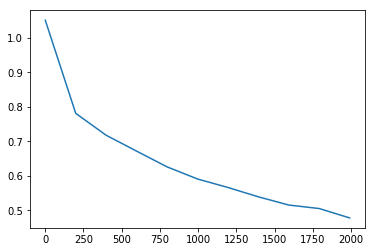

In [164]:
#Defining the parameters
k = 1999
max_iters = 100
threshold = 1e-2
#Grid-searching the number of clusters (by 100s)
losses=[]
for i in range(1,k, k//10):
    print('For k=',i,':')
    losses.append(kmeans(cli_vs_mov, i, max_iters, threshold)[2])
plt.plot(range(1,k, k//10),losses)

For k= 100 :
The current iteration of k-means is: 0,                the average loss is 2.3910609252767903.
The current iteration of k-means is: 1,                the average loss is 0.8978349223217501.
The current iteration of k-means is: 2,                the average loss is 0.8513198478410563.
The current iteration of k-means is: 3,                the average loss is 0.8377459732693425.
The current iteration of k-means is: 4,                the average loss is 0.8331816724819094.
For k= 120 :
The current iteration of k-means is: 0,                the average loss is 2.381802345087717.
The current iteration of k-means is: 1,                the average loss is 0.886466588979112.
The current iteration of k-means is: 2,                the average loss is 0.8420427486286866.
The current iteration of k-means is: 3,                the average loss is 0.8297127135348566.
The current iteration of k-means is: 4,                the average loss is 0.8248876599456003.
For k= 140 :
The current i

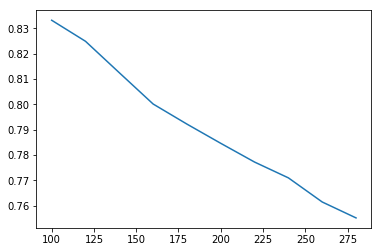

In [166]:
#Defining the parameters
k_min = 100
k_max=300
max_iters = 100
threshold = 1e-2
#Grid-searching the number of clusters (by 10s)
losses=[]
for i in range(k_min,k_max, (k_max-k_min)//10):
    print('For k=',i,':')
    losses.append(kmeans(cli_vs_mov, i, max_iters, threshold)[2])
plt.plot(range(k_min,k_max, (k_max-k_min)//10),losses)

For k= 150 :
The current iteration of k-means is: 0,                the average loss is 2.371951124060864.
The current iteration of k-means is: 1,                the average loss is 0.8652176310151121.
The current iteration of k-means is: 2,                the average loss is 0.8219030150864881.
The current iteration of k-means is: 3,                the average loss is 0.809616308256213.
The current iteration of k-means is: 4,                the average loss is 0.804904538220419.
The current iteration of k-means is: 5,                the average loss is 0.8025940419217151.
The current iteration of k-means is: 6,                the average loss is 0.801680983029254.
The current iteration of k-means is: 7,                the average loss is 0.8013089750691703.
The current iteration of k-means is: 8,                the average loss is 0.8010910819560388.
The current iteration of k-means is: 9,                the average loss is 0.8008455195217388.
The current iteration of k-means is: 10, 

The current iteration of k-means is: 0,                the average loss is 2.342518646467537.
The current iteration of k-means is: 1,                the average loss is 0.8648887978910592.
The current iteration of k-means is: 2,                the average loss is 0.8200279128663096.
The current iteration of k-means is: 3,                the average loss is 0.8070526133927232.
The current iteration of k-means is: 4,                the average loss is 0.802688326004837.
The current iteration of k-means is: 5,                the average loss is 0.8011608246018681.
The current iteration of k-means is: 6,                the average loss is 0.8003056050662907.
The current iteration of k-means is: 7,                the average loss is 0.7998840674691439.
The current iteration of k-means is: 8,                the average loss is 0.7995783876186495.
The current iteration of k-means is: 9,                the average loss is 0.7994242769773401.
The current iteration of k-means is: 10,            

The current iteration of k-means is: 11,                the average loss is 0.7965867411034313.
The current iteration of k-means is: 12,                the average loss is 0.79653544910663.
The current iteration of k-means is: 13,                the average loss is 0.7965139238066964.
The current iteration of k-means is: 14,                the average loss is 0.7964937177856125.
The current iteration of k-means is: 15,                the average loss is 0.7964724508895116.
The current iteration of k-means is: 16,                the average loss is 0.7964568314284276.
The current iteration of k-means is: 17,                the average loss is 0.7964522601361508.
The current iteration of k-means is: 18,                the average loss is 0.7964452486771223.
The current iteration of k-means is: 19,                the average loss is 0.7964386461709749.
The current iteration of k-means is: 20,                the average loss is 0.7964384654965017.
For k= 159 :
The current iteration of k-me

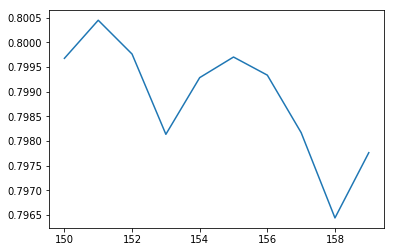

In [170]:
#Defining the parameters
k_min = 150
k_max=160
max_iters = 100
threshold = 1e-6
#Grid-searching the number of clusters
losses=[]
for i in range(k_min,k_max):
    print('For k=',i,':')
    losses.append(kmeans(cli_vs_mov, i, max_iters, threshold)[2])
plt.plot(range(k_min,k_max),losses)

In [58]:
#k chosen using the above plots
k_opt=155
#Defining the parameters
max_iters = 100
threshold = 1e-3
#Generating a prediction
assignments, mu, _=kmeans(cli_vs_mov, k_opt, max_iters, threshold)
classified=cli_vs_mov.copy()
mu_rounded=np.round(mu)
for i in range(k_opt):
    classified[assignments==i]=np.where(np.isnan(classified[assignments==i]),mu_rounded[i],classified[assignments==i])
classified.head()
    

The current iteration of k-means is: 0,                the average loss is 2.3424527087484015.
The current iteration of k-means is: 1,                the average loss is 0.8657146007127116.
The current iteration of k-means is: 2,                the average loss is 0.8219607169059009.
The current iteration of k-means is: 3,                the average loss is 0.8107149523374059.
The current iteration of k-means is: 4,                the average loss is 0.806719887820255.
The current iteration of k-means is: 5,                the average loss is 0.8051634244994335.
The current iteration of k-means is: 6,                the average loss is 0.8043983841172833.


Col,1,10,100,1000,101,102,103,104,105,106,...,990,991,992,993,994,995,996,997,998,999
Row,,,,,,,,,,,,,,,,,,,,,
1,4.0,5.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,...,2.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0
10,2.0,3.0,3.0,4.0,4.0,3.0,2.0,2.0,3.0,4.0,...,2.0,3.0,3.0,2.0,4.0,5.0,4.0,4.0,4.0,3.0
100,3.0,5.0,3.0,3.0,5.0,5.0,3.0,2.0,2.0,4.0,...,3.0,3.0,4.0,3.0,3.0,1.0,3.0,3.0,3.0,4.0
1000,4.0,2.0,4.0,2.0,5.0,5.0,4.0,3.0,4.0,4.0,...,4.0,3.0,4.0,2.0,4.0,5.0,1.0,4.0,2.0,3.0
10000,5.0,4.0,4.0,3.0,2.0,4.0,3.0,2.0,3.0,3.0,...,4.0,2.0,1.0,1.0,2.0,4.0,3.0,3.0,2.0,2.0


In [59]:
#Converting the columns back to the Col column and making Row a column instead of an index
classified=pd.melt(classified.reset_index(), id_vars=['Row'], var_name='Col', value_name='Rating')
classified.head()

,Row,Col,Rating
0,1,1,4.0
1,10,1,2.0
2,100,1,3.0
3,1000,1,4.0
4,10000,1,5.0


In [60]:
#Converting Row and Col values into an id
classified.index='r'+classified['Row']+'_c'+classified['Col']
classified=classified.drop(columns=['Row','Col'])
classified.head()

,Rating
r1_c1,4.0
r10_c1,2.0
r100_c1,3.0
r1000_c1,4.0
r10000_c1,5.0


In [61]:
#Loading the sample submission data
sample_sumbission=pd.read_csv('sampleSubmission.csv')
sample_sumbission.head()

,Id,Prediction
0,r37_c1,3
1,r73_c1,3
2,r156_c1,3
3,r160_c1,3
4,r248_c1,3


In [62]:
classified=classified[classified.index.isin(list(sample_sumbission['Id']))].reset_index().rename(columns={'index': 'Id', 'Rating':'Prediction'})
classified.head()

,Id,Prediction
0,r1000_c1,4.0
1,r1141_c1,3.0
2,r1146_c1,4.0
3,r1157_c1,4.0
4,r1184_c1,4.0


In [65]:
#Exporting the predictions
classified.to_csv('submission.csv')